S.a.M: Song and Music Recommendation System 

Hi! My name is S.a.M. I'm an AI recommendation system that allows the user to input their favorite movie or song and get recommendations based off it. This is posible through the use of content based filtering, principal component analysis, k-means clustering, cosine similartiy and eueclidean distance. I'm split up into 3 main compoenents, there's a msuic feature, a movie feature, and an interactive menu. Let's begin with the music componenet. 

Step 1: Loading the data
In order to start, we will have to import the necessary libraries and resources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

We will now read the CSV file containing our dataset and put it in a pandas dataframe. In dataframe format, we will able to show important information such as the format of the dataset and its shape.

In [2]:
df = pd.read_csv(r"C:\Users\kylek\Downloads\CS 450 Project\data\dataset.csv", index_col=0) #index_col=0 used to removed any unnamed columns which our dataset had one
df.head(10) #the head() function usually prints out the first 5 rows of the dataset but we will show the first 10

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [3]:
print("The dimensions of our dataset are:", df.shape)

The dimensions of our dataset are: (114000, 20)


As seen above, our dataset consists of 114,000 songs with 20 features. These features consists of basic information of the song such as track name, artist, and album. But, it also has more interesting features that might be useful for use such as, loudness, acousticness, tempo, and genre. These can be useful when it comes to creating clusters.

Step 2: Cleaning the Data
Before implementing clusters, we first need to clean our data of unnecessary columns. Clustering works best if we keep features that are numerical values. This will make our recommendation system more interesting as we will be recommending songs that sound similar rather than something simple such as genre. To achieve this, we will drop columns that do not contain numerical data. We will also be dropping NaN columns which are columns that contain missing or incomplete data.

In [4]:
df.dropna(inplace=True) #we will first drop any NaN values for efficiency
df.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


In [5]:
#now we have to manually drop any remaining uneccessary columns such as 'track_id', 'explicit', and 'track_genre'
dropped_df = df.drop(['track_id', 'artists','album_name', 'track_name','explicit', 'track_genre'], axis=1)
dropped_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
5,58,214240,0.688,0.4810,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4
6,74,229400,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3
7,80,242946,0.703,0.4440,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4
8,74,189613,0.625,0.4140,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4
9,56,205594,0.442,0.6320,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4


In [6]:
print("New dimensions of dataset:", dropped_df.shape)

New dimensions of dataset: (113999, 14)


Last step before implementing clusters is to normalize our data. If we did not do that, our graph would be skewed to favored larger values such as duration.

In [7]:
final_df = dropped_df.copy()
final_df = StandardScaler().fit_transform(final_df)
final_df = pd.DataFrame(final_df, columns=dropped_df.columns)
final_df.head(10)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1.782624,0.024557,0.629239,-0.717147,-1.210434,0.300825,-1.326297,0.551843,-0.850193,-0.504111,0.758735,0.929315,-1.141854,0.221824
1,0.975625,-0.730889,-0.845908,-1.889974,-1.210434,-1.784739,0.753979,-0.078995,1.831744,-0.504097,-0.591216,-0.798681,-1.489708,0.221824
2,1.065291,-0.160353,-0.742187,-1.122667,-1.491334,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,-0.507172,-1.365679,-1.528303,0.221824
3,1.692957,-0.243236,-1.733301,-2.312987,-1.491334,-2.039246,0.753979,-0.457309,1.774605,-0.503886,-0.428381,-1.276965,1.987857,-2.089669
4,2.186123,-0.271942,0.295026,-0.788709,-0.929534,-0.282751,0.753979,-0.303146,0.463409,-0.504115,-0.686290,-1.184394,-0.073343,0.221824
5,1.110125,-0.128534,0.698386,-0.637633,0.194067,-0.108971,0.753979,0.192445,-0.077910,-0.504115,-0.128976,0.740315,-0.804943,0.221824
6,1.827457,0.012758,-0.920818,-1.965512,-0.929534,-0.111953,0.753979,-0.464875,1.630253,-0.504105,-0.642167,-1.533465,0.638342,-2.089669
7,2.096457,0.139007,0.784820,-0.784734,1.598568,-0.213159,0.753979,-0.406236,0.734069,-0.504115,-0.610651,0.917743,0.961110,0.221824
8,1.827457,-0.358059,0.335362,-0.904004,-1.491334,-0.087696,0.753979,-0.451634,-0.062874,-0.504115,-0.328579,0.751887,0.264870,0.221824
9,1.020458,-0.209115,-0.719138,-0.037305,-1.210434,0.296053,0.753979,-0.521622,0.334094,-0.490579,-0.735666,-1.072537,-1.442674,0.221824


Step 3: Implementing Principal Component Analysis
For our clusters to be as efficient as possible, we will first reduce the dimensionality of our data to make our calculations more efficient. We will be doing this using Principal Component Analysis (PCA).

PCA is a dimension reduction algorithm that reduces the dimensionality of a dataset while still maintaining crucial information. When combined with K-means clustering, it will lead to better defined clusters

We begin by figuring out how many principal components we can reduce our data too. We do this by creating a PCA instance which will use as many components as the number of features in our data. We will then plot the cumulative explained variance ratio for each number of components.

In [8]:
pca = PCA()
pca_df = pca.fit_transform(final_df)
pca.explained_variance_ratio_

array([0.2119415 , 0.10961802, 0.09077169, 0.0833671 , 0.07410521,
       0.06989378, 0.064446  , 0.06321516, 0.05946335, 0.05581412,
       0.05211154, 0.03203305, 0.02323346, 0.00998601])

As seen above, we have 14 principal components since we have 14 features and each component has there own percentage of explained variance. We will plot the ratio and find at which number of components will we have explained variance ratio above 0.80.

Text(0, 0.5, 'cumulative explained variance')

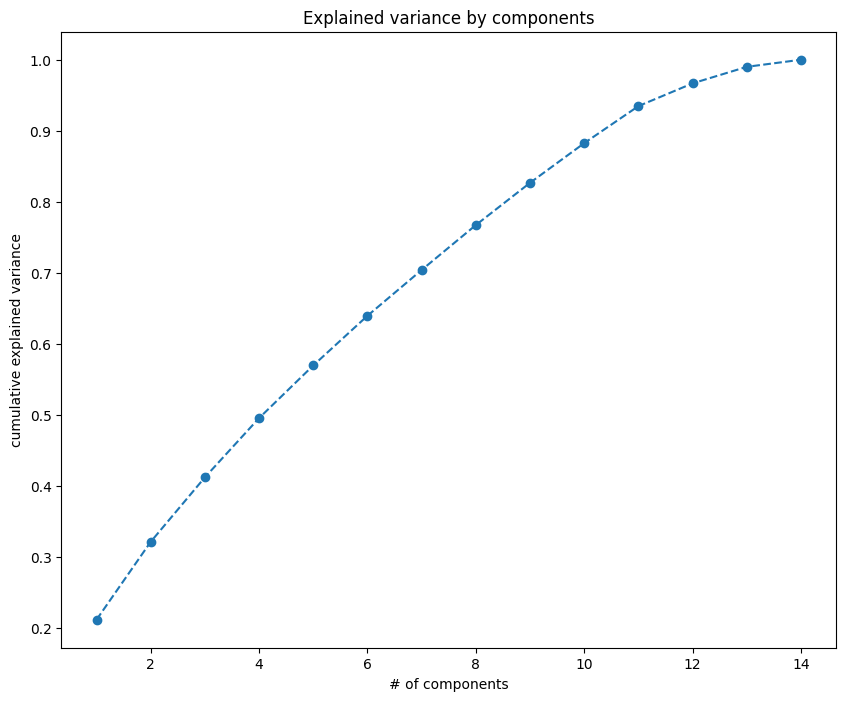

In [9]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(pca.explained_variance_ratio_.cumsum()) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('# of components')
plt.ylabel('cumulative explained variance')

According to our graph, at 9 principal components we will have cumulative explained variance ratio above 0.80 which means that will be the number of components we will use.

In [10]:
pca = PCA(n_components=9)
pca_df = pca.fit_transform(final_df)
print(sum(pca.explained_variance_ratio_)) #to verify that 9 is the right number

0.8268218127381162


Step 4. Implementing K-means Clustering
Step 4a. Elbow Method
For K-means clustering to work, we need to figure out the k number of clusters for our data. This is a number that has to be figured out by us. It is important to have the right amount of clusters as having too little clusters leads to underfitting and have too many clusters leads to overfitting.

To figure out how many clusters we will be using, we will be using the Elbow Method. This method involves creating a K-means clustering model with varying amounts of clusters, calculating the inertias of each and plotting it to see at which point do we see a elbow-like bend in the graph. So, we will be taking our Principal Component model and running it through the clustering algorithm to find the optimal amount of clusters.

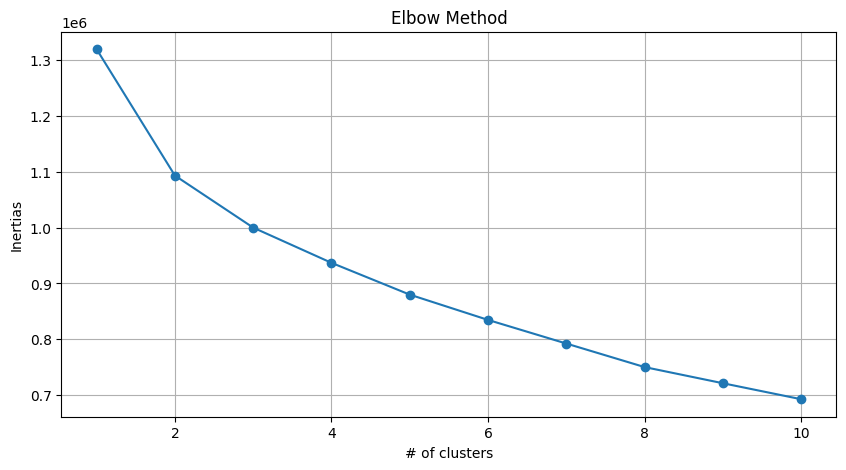

In [11]:
inertias = []
means = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(pca_df)
    means.append(i)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(means, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel("# of clusters")
plt.ylabel("Inertias")
plt.grid(True)
plt.show()

We pick the point in which the inertia starts decreasing in a linear manner which appears to be point 3. We will be forming 3 clusters.

In [12]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(final_df)
df['Cluster'] = kmeans.labels_ #assigns each song into their respective cluster
final_df['Cluster'] = kmeans.labels_ #does the same into our modified dataframe
df.head(50)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,Cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,0
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,...,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,1
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,0
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,1
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,...,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,1
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,...,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,2


In [13]:
print(df.shape)

(113999, 21)


In [14]:
final_df.head(50)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,1.782624,0.024557,0.629239,-0.717147,-1.210434,0.300825,-1.326297,0.551843,-0.850193,-0.504111,0.758735,0.929315,-1.141854,0.221824,1
1,0.975625,-0.730889,-0.845908,-1.889974,-1.210434,-1.784739,0.753979,-0.078995,1.831744,-0.504097,-0.591216,-0.798681,-1.489708,0.221824,0
2,1.065291,-0.160353,-0.742187,-1.122667,-1.491334,-0.293289,0.753979,-0.273827,-0.315489,-0.504115,-0.507172,-1.365679,-1.528303,0.221824,0
3,1.692957,-0.243236,-1.733301,-2.312987,-1.491334,-2.039246,0.753979,-0.457309,1.774605,-0.503886,-0.428381,-1.276965,1.987857,-2.089669,0
4,2.186123,-0.271942,0.295026,-0.788709,-0.929534,-0.282751,0.753979,-0.303146,0.463409,-0.504115,-0.686290,-1.184394,-0.073343,0.221824,0
5,1.110125,-0.128534,0.698386,-0.637633,0.194067,-0.108971,0.753979,0.192445,-0.077910,-0.504115,-0.128976,0.740315,-0.804943,0.221824,1
6,1.827457,0.012758,-0.920818,-1.965512,-0.929534,-0.111953,0.753979,-0.464875,1.630253,-0.504105,-0.642167,-1.533465,0.638342,-2.089669,0
7,2.096457,0.139007,0.784820,-0.784734,1.598568,-0.213159,0.753979,-0.406236,0.734069,-0.504115,-0.610651,0.917743,0.961110,0.221824,1
8,1.827457,-0.358059,0.335362,-0.904004,-1.491334,-0.087696,0.753979,-0.451634,-0.062874,-0.504115,-0.328579,0.751887,0.264870,0.221824,1
9,1.020458,-0.209115,-0.719138,-0.037305,-1.210434,0.296053,0.753979,-0.521622,0.334094,-0.490579,-0.735666,-1.072537,-1.442674,0.221824,2


In [15]:
print(final_df.shape)

(113999, 15)


Now we will visualize our data. To do this well be plotting the first two principal components of our dataset while showing the cluster that each song is in. We will only be plotting two as it is not possible to plot 9 components but 2 is enough to showcase our data.

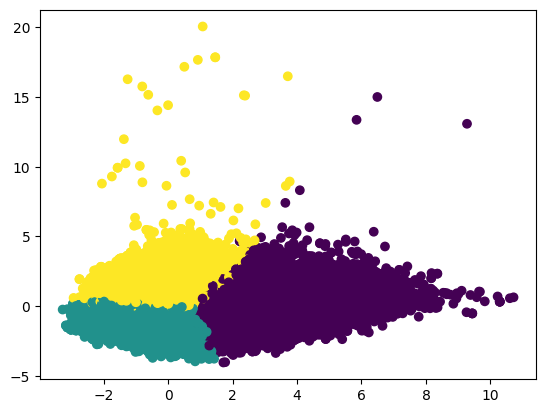

In [16]:
final_df['pca_1'] = pca_df[:,0]
final_df['pca_2'] = pca_df[:,1]
plt.scatter(final_df['pca_1'], final_df['pca_2'], c=final_df['Cluster'])
plt.show()

We have successfully clustered our songs! It is time to create our song recommending functions.

Step 5. Create Song Recommender
With our songs clustered, to create our recommender we need a way to locate song the user inputs in our database, find the cluster number and recommend songs inside that cluster

In [17]:
def get_Song_Index(track_name, df):
    try:
        track_index = df[df['track_name'] == track_name].index[0] #Finds the id of the first matching result
        return track_index
    except IndexError:
        return None

In [18]:
def get_recommendations(track_name, df):
    track_index = get_Song_Index(track_name, df)
    print('You chose: ' + track_name + ' by ' + df.loc[track_index]['artists'])
    print('Here are your recommendations:')
    cluster = df.loc[track_index]['Cluster'] #finds the cluster of the inputted song
    filter = (df['Cluster'] == cluster)
    
    filtered_df = df[filter] #creates a dataframe with only songs of the indicated cluster
    chosen_index = filtered_df.index.get_loc(track_index)
    start_index = max(0, chosen_index - 5)
    end_index = min(len(filtered_df), chosen_index + 6)
    for i in range(start_index, end_index):
        if i != chosen_index:
            recommendation = filtered_df.iloc[i]
            print(recommendation['track_name'] + ' by ' + recommendation['artists'])

In [19]:
get_recommendations('Is This It', df)

You chose: Is This It by The Strokes
Here are your recommendations:
Nice Guy by Hector Gachan
Welcome My Friend by OKAMOTO'S
Yellow by Pity Party (Girls Club)
2516 by Luna Li
The Bakery by Arctic Monkeys
Bigger Boys and Stolen Sweethearts by Arctic Monkeys
Whistle For The Choir by The Fratellis
Short Change Hero by The Heavy
D is for Dangerous by Arctic Monkeys
Tranquility Base Hotel & Casino by Arctic Monkeys


Due to the vast nature of our clusters, some of the recommendations may seem outlandish and only vaguely similar. To improve our recommender, we will introduce euclidean distance calculations into our recommender. We will be measuring the distance between our inputted song and every other song in the cluster and recommend the songs with the shortest distance to our song. The calculation will be based off certain features to make sure that our songs will be as close as possible.

In [20]:
def get_euclidean_recommendations(track_name, features, df, final_df, n_songs=10):
    
    track_index = get_Song_Index(track_name, df)
    print('You chose: ' + track_name + ' by ' + df.loc[track_index]['artists'])
    print('Here are your recommendations:')
    track_cluster = final_df.loc[track_index]['Cluster']
    cluster = final_df[final_df['Cluster'] == track_cluster]
    cluster_df = cluster[features]
    
    target_song = cluster_df.loc[track_index, features]
    target_song = target_song.to_frame().T
    
    distances = euclidean_distances(target_song, cluster_df)
    distances = distances.flatten()
    sorted_indices = np.argsort(distances)
        
    most_similar_songs = cluster_df.iloc[sorted_indices[:n_songs + 1]]
    indices = most_similar_songs.index
    songs_in_df = df.loc[indices]
    
    for i in range(n_songs + 1):
        if songs_in_df.iloc[i]['track_name'] != track_name:
            print(songs_in_df.iloc[i]['track_name'] + ' by ' + songs_in_df.iloc[i]['artists'])

In [21]:
features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
           'instrumentalness', 'liveness', 'valence', 'tempo'] #the features we will be comparing
get_euclidean_recommendations('Is This It', features, df, final_df)

You chose: Is This It by The Strokes
Here are your recommendations:
Destroy Everything You Touch by Ladytron
If I Could Find You (Eternity) by The Holydrug Couple
Skiptracing by Mild High Club
Ishq Mubarak by Arijit Singh
You and I Both by Jason Mraz
Écoute Chérie by Vendredi sur Mer
紅 by 告五人
I Know A Place by Jay Reatard
Touch, Peel And Stand by Days Of The New
Kiri Ga Naikara by Fujii Kaze


We've successfully implemented the music component of our recommendation system. Now let's move onto the movie portion. 

Step 1: Loading data
 
In order to start, we must import additonal libraries and resources that will be needed. 

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
from datetime import datetime

We use a different dataset for our movie section so we have to read the new CSV files that contains our dataset and put it in a pandas dataframe. In dataframe format, we will be able to show important information such as the format of the dataset and its shape. Df1 contains movie_id, cast, and crew information. Df2 contains budget, genre, homepage, id, keywords, and other movie features. We will eventually combine the datasets.

In [23]:
df1 = pd.read_csv(r"C:\Users\kylek\Downloads\CS 450 Project\data\tmdb_5000_credits.csv")
df1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


This is our first dataset. Now let's take a look at our second.

In [24]:
df2 = pd.read_csv(r"C:\Users\kylek\Downloads\CS 450 Project\data\tmdb_5000_movies.csv")
df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Now lets join the two datasets together and take a look at our new dataset.

In [25]:
df1.columns = ['id','tittle','cast','crew']
movie_df = df2.merge(df1,on='id')
movie_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Let's take a look at the shape our dataset. This will tell us how many movies and features are in our dataset.

In [26]:
movie_df.shape

(4803, 23)

We are returned a tupple, (4803, 23). This means that in our dataset, we have 4803 movies, each movie containing 23 features.

We will begin our recommendation system with content based filtering. The content of the movie (overview, cast, crew, keyword, and tagline) are used to compute a similarity score with other movies. Then the movies with the highest similarity score are recommended. We'll start by computing the pairwise similarity scores for all movies based on their plot description. The plot description is given in the overview feature of our dataset.

Let's take a look.

In [27]:
movie_df['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

Now we must perform data preprocessing in order to transform our raw data into something usable. We want to perform text processing in order to accurately analyze the plot description for each movie. This is achieved by computing the Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview. Term frequency is the relative frequency of a word in a document. It's given as (term instance / total instance). Inverse Document Frequency is the relative count of documents containing the term and is given as log(number of documents / documents with term). The importance of each word to the document is equal to TF * IDF. This gives you a matrix where each column represents a word in the overview vocabulary and each row represents a movie. We perform these actions in order to reduce the importance of words that occur frequently in plot overviews.

In [28]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movie_df['overview'] = movie_df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie_df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

There's 20,978 words used to describe the 4803 movies in our dataset.

Using this matrix, we can now compute a similarity score. There are multiple methods for finding a similary score such as eculidean, pearson and cosine similarty score. No method is better than another, they all have advantages for certain sceanrios. In this case, we will be using the cosine similarty score to calculate a numeric quanity that represent the similarity between two movies.

Similarity = cos(θ) = (A * B) / ||A|| ||B|| (dot product)

Since we have used the TF-IDF vectorizer, calculating the dot product will direclty give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel().

In [29]:
#Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Now we will define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. We need a way to identify the index of a movie in our metadata DataFrame given its title. This can be achieved by reverse mapping the movies titles and DataFrame indices.

In [30]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

Basic Steps of Recommendation System

1. Get the index of the movie based off title
2. Compute cosine similarity scores for the particular movie with all movies. Then convert it into a list of tuples where the first element is its position and the second is the similarity score
3. Sort the list of tuples based on the similarity scores
4. Get the top 10 elements of this list. Ignore the first element since it's refering to itself
5. Return the titles corresponding to the indices of the top elements

In [31]:
#Function that takes in movie title as input and outputs most similar movies
def get_content_recommendations(title, cosine_sim=cosine_sim):
    try:
        # Get the index of the movie that matches the title
        idx = indices[title]

        # Get the pairwise similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Create a DataFrame with the top 10 most similar movies and their similarity scores
        result_df = pd.DataFrame(columns=['Title', 'Similarity Score'])
        result_df['Title'] = movie_df['title'].iloc[movie_indices]
        result_df['Similarity Score'] = [i[1] for i in sim_scores]

        # Return the top 10 most similar movies
        return result_df
    except KeyError:
        print(f"Sorry, the movie '{title}' was not found in our database. Please check the title and try again.")
        return None

Let's test out our content based recommendation by inputing our favorite movie.

In [32]:
get_content_recommendations('Batman & Robin')

,Title,Similarity Score
1359,Batman,0.178817
299,Batman Forever,0.164285
428,Batman Returns,0.138518
212,The Day After Tomorrow,0.137278
514,Ice Age: The Meltdown,0.134456
3,The Dark Knight Rises,0.130455
4768,The Exploding Girl,0.120091
3854,"Batman: The Dark Knight Returns, Part 2",0.109152
65,The Dark Knight,0.106896
9,Batman v Superman: Dawn of Justice,0.105312


Our recommendation system does a good job at finding movies with similar plot descriptions but the quality of the recommendation could improve. For example, "Batman & Robin" returns all batman movies rather than movies with similar actors. We can improve our movie recommendation by building a recommendation based on 4 key features - movie plot keywords, the director, the 3 most popular actors, and the genre. In order to achieve this, we must manipulate our data. 

In [33]:
#Credits, Genres and Keywords Based Recommender
attributes = ['cast', 'crew', 'keywords', 'genres']
for attribute in attributes:
    movie_df[attribute] = movie_df[attribute].apply(literal_eval)

Next we'll write functions that allow us to extract information from each feature. 

In [34]:
#Extract director's name, return none if not found
def extract_director(crew_data):
    for crew_member in crew_data:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return None 

In [35]:
#Returns the top 3 elements from list 
def get_elements(elements):
    if isinstance(elements, list):
        names = [element['name'] for element in elements][:3]
        return names
    return []

In [36]:
#Define new director, cast, genres and keywords features that are in a suitable form.
movie_df['director'] = movie_df['crew'].apply(extract_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movie_df[feature] = movie_df[feature].apply(get_elements)

In [37]:
#Print the new features of the first 3 films
movie_df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


Now we must normalize our data. We have to convert the names nad keywords into lowercase and delete the spaces between them. This way our vectorizer doesn't count the Ryan of "Ryan Reynolds" and "Ryan Gosling" as the same. 

In [38]:
#Normalize data by converting strings to lowercase and removing spaces 
def normalize_data(data):
    if isinstance(data, list):
        return [str.lower(item.replace(" ", "")) for item in data]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(data, str):
            return str.lower(data.replace(" ", ""))
        else:
            return ''

In [39]:
#Normalize all features
features = ['cast', 'keywords', 'director', 'genres']
for feature in features:
    movie_df[feature] = movie_df[feature].apply(normalize_data)

Now let's create our metadata soup (a string that contains all the metadata that we want to feed to our vectorizer (actors, director, and keywords))

In [40]:
def create_soup(features):
    return ' '.join(features['keywords']) + ' ' + ' '.join(features['cast']) + ' ' + features['director'] + ' ' + ' '.join(features['genres'])
movie_df['soup'] = movie_df.apply(create_soup, axis=1)

This step is very similar to the text processing we pefromed with TF-IDF. This time we are going to utilize COuntVectorizer(). 

In [41]:
vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(movie_df['soup'])

We now created a word_matrix. We are able to use this word matrix to calcualte the cosine simialrty score. 

In [42]:
#Calculate the cosine similartiy matrix 
cosine_similarity_matrix = cosine_similarity(word_matrix, word_matrix)

In [43]:
#Reset index of our main DataFrame and construct reverse mapping as before
movie_df = movie_df.reset_index()
indices = pd.Series(movie_df.index, index=movie_df['title'])

We can now reuse our get_recommendation() function by passing in the new cosine_similarity_matrix 

In [44]:
get_content_recommendations('The Dark Knight Rises', cosine_similarity_matrix)

,Title,Similarity Score
65,The Dark Knight,0.700000
119,Batman Begins,0.700000
4638,Amidst the Devil's Wings,0.547723
1196,The Prestige,0.400000
3073,Romeo Is Bleeding,0.400000
3326,Black November,0.358569
1503,Takers,0.335410
1986,Faster,0.335410
303,Catwoman,0.316228
747,Gangster Squad,0.316228


Now that we have implemented our song and movie compoenents we are able to create a user-friendly interactive menu. 

Let's create functions that retrieve our recommendations based on user input. 

Now let's define a function that shows an interactive menu 

In [45]:
def get_movie_recommendations(title, movies):
    if title in movies['title'].values: #check if movie exists in dataset
        print(get_content_recommendations(title, cosine_similarity_matrix)) #if movie exists print recommendations
    else:
        print("So sorry! It seems as if the movie you are searching for is not available.\n")
        print("Either the movie is not present in our database or was typed incorrectly.\n")
        print("Make sure to spell the movie exactly as the title appears and try again.")

def get_song_recommendations(title, songs):
    if title in songs['track_name'].values: #check if song exists in dataset
        print(get_euclidean_recommendations(title, features, df, final_df)) #if song exists print recommendations
    else:
        print("So sorry! It seems as if the song you are trying to search for is not available.\n")
        print("Either the song is not present in our database or was typed incorrectly.\n")
        print("Make sure to spell the song exactly as it appears on Spotify and try again.")

def show_menu():
    movies = df2 #load movie dataset
    songs = df #load song dataset
    
    print("Hi! My name is S.a.M. I'm your Song and Movie recommendation system. I can't wait to get started.")
    
    #Start an infinite loop to continually offer options until the user exists 
    while True:
        print("\nPlease select one of the following options")
        print("1. Get movie recommendations")
        print("2. Get song recommendations")
        print("3. Exit")
        choice = input("Please enter your choice: ")
        
        if choice == '1':
            print("Please enter the movie title you want a recommendation for:")
            title = input("Please enter the movie title you want a recommendations for: ")
            get_movie_recommendations(title, movies)
        elif choice == '2':
            print("Please enter the song title you want a recommednation for")
            title = input("Please enter the song title you want a recommendation for: ")
            get_song_recommendations(title, songs)
        elif choice == '3':
            print("Thank you for listening to my recommednations. Good bye :) ")
            break
        else:
            print("I'm sorry but I didn't understand your answer. Please select 1 for movie recommendations. 2 for song recommednations and 3 to exit the program.")

show_menu()

Hi! My name is S.a.M. I'm your Song and Movie recommendation system. I can't wait to get started.

Please select one of the following options
1. Get movie recommendations
2. Get song recommendations
3. Exit
Please enter the movie title you want a recommendation for:
                                        Title  Similarity Score
206                       Clash of the Titans          0.400000
71      The Mummy: Tomb of the Dragon Emperor          0.358569
786                         The Monkey King 2          0.335410
103                 The Sorcerer's Apprentice          0.316228
131                                   G-Force          0.316228
215    Fantastic 4: Rise of the Silver Surfer          0.316228
466                          The Time Machine          0.316228
715                         The Scorpion King          0.316228
1    Pirates of the Caribbean: At World's End          0.300000
5                                Spider-Man 3          0.300000

Please select one of the fol

KeyError: "None of [Index(['cast', 'keywords', 'director', 'genres'], dtype='object')] are in the [columns]"